In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt 
import torchvision

In [3]:
# things to try: 
# 1. larger network 
# 2. better normalization with batchnorm 
# 3. change arch to cnn 

class Discriminator(nn.Module):
    def __init__(self, in_features): 
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
        )
        
    def forward(self, x):
        return self.disc(x)
    
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim, hidden_dim=128):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, hidden_dim * 4),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, hidden_dim * 8),
            nn.BatchNorm1d(hidden_dim * 8),
            nn.ReLU(),
            nn.Linear(hidden_dim * 8, hidden_dim * 4),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, img_dim),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.gen(x)

In [4]:
device = 'cuda'
z_dim = 64 
in_features = 28 * 28 
lr = 3e-4
batch_size = 32
num_epochs = 2000

transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.5), (0.5))
])

ds = datasets.MNIST('dataset/', transform=transform, download=True)
loader = DataLoader(ds, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14427524.66it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 460975.85it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4393912.85it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3242091.35it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



Epoch[0/2000] Loss D 0.719, LossG: 0.600
Epoch[1/2000] Loss D 0.730, LossG: 0.954
Epoch[2/2000] Loss D 0.397, LossG: 2.456
Epoch[3/2000] Loss D 0.561, LossG: 0.934
Epoch[4/2000] Loss D 0.917, LossG: 0.773
Epoch[5/2000] Loss D 0.634, LossG: 0.949
Epoch[6/2000] Loss D 0.815, LossG: 0.646
Epoch[7/2000] Loss D 0.844, LossG: 0.571
Epoch[8/2000] Loss D 0.662, LossG: 0.908
Epoch[9/2000] Loss D 0.703, LossG: 0.883
Epoch[10/2000] Loss D 0.623, LossG: 1.015
Epoch[11/2000] Loss D 0.746, LossG: 0.739
Epoch[12/2000] Loss D 0.615, LossG: 0.946
Epoch[13/2000] Loss D 0.693, LossG: 0.783
Epoch[14/2000] Loss D 0.716, LossG: 0.828
Epoch[15/2000] Loss D 0.710, LossG: 0.856
Epoch[16/2000] Loss D 0.573, LossG: 1.099
Epoch[17/2000] Loss D 0.535, LossG: 1.156
Epoch[18/2000] Loss D 0.694, LossG: 0.857
Epoch[19/2000] Loss D 0.758, LossG: 0.969
Epoch[20/2000] Loss D 0.737, LossG: 0.918
Epoch[21/2000] Loss D 0.721, LossG: 0.775
Epoch[22/2000] Loss D 0.560, LossG: 0.952
Epoch[23/2000] Loss D 0.540, LossG: 1.178
Ep

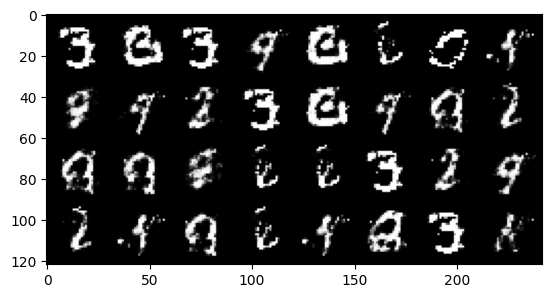

In [5]:


disc = Discriminator(in_features).to(device)
gen = Generator(z_dim, in_features).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

opt_disc = optim.Adam(disc.parameters(), lr)
opt_gen = optim.Adam(gen.parameters(), lr)

criterion = nn.BCEWithLogitsLoss()

for epoch in range(num_epochs):
    for batch_idx, (real, label) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]
        
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        
        disc_real = disc(real).view(-1).to(device)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward()
        opt_disc.step()
        
        # Train Generator
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        
        if batch_idx == 0:
            print(f'Epoch[{epoch}/{num_epochs}]',
                 f'Loss D {lossD:.3f}, LossG: {lossG:.3f}')
        if epoch % 200 == 0: 
            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img = img_grid_fake.permute(1, 2, 0).cpu()
                plt.imshow(img)


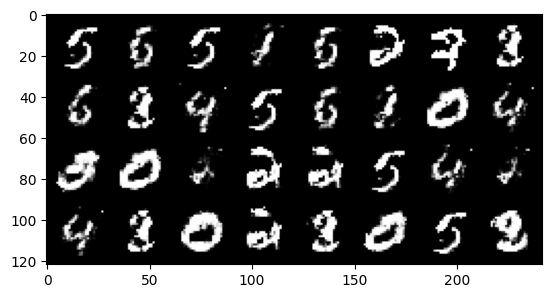

In [6]:
with torch.no_grad():
    fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
    img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
    img = img_grid_fake.permute(1, 2, 0).cpu()
    plt.imshow(img)